# Initial Prototyping of Phrasal Chunking


We first look at a simpler summary of the entire Phrasal Chunking algorithm proposed:

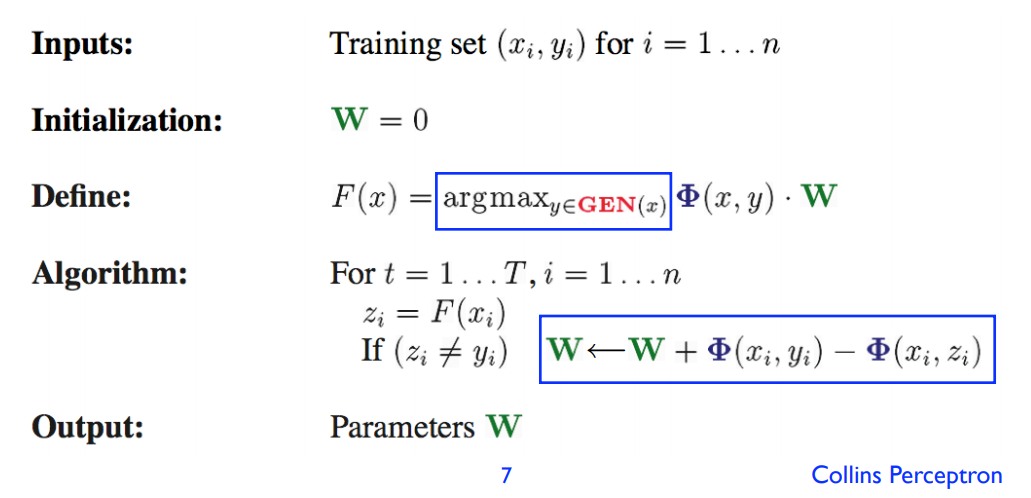

We observe that there are a few parameters that first need to be straightened out for implementation, namely:
    
* **Representation of $(x_{i},y_{i})$ from Training set**
* **Representation of $\Phi(x_{i},y_{i})$**
* **Storage of a $(z_{i})$ array/container**
* **Subtraction and Addition operations/functions on the W container set with the $\Phi(x_{i},y_{i})$ values**

Implementation will only proceed smoothly once these points have been decided. As such, notes on the research of these implementation details will be noted in this section.

We note that the variable:
```
feat_vec
```
Is a suitable container for the $W$ vector. As such, we will assume that it is a dictionary that contains key/value pairs. 

Since we can assume from the pseudocode that a **merge** of $(labels, features)$ will be suitable for the representation of $\Phi(x_{i},y_{i})$ where $(x,y)$ corresponds to $(labels, features)$, we will have to take a look at the structure of $(labels, features)$ in detail.

Upon looking at *data/train.feats.dev*, we observe the following structure to be taken in after *perc.read_labeled_data* is run:

```
U00:_B-2
U01:_B-1
U02:Confidence
U03:in
U04:the
U05:_B-1/Confidence
U06:Confidence/in
U10:_B-2
U11:_B-1
U12:NNq
U13:IN
U14:DT
U15:_B-2/_B-1
U16:_B-1/NN
U17:NN/IN
U18:IN/DT
U20:_B-2/_B-1/NN
U21:_B-1/NN/IN
U22:NN/IN/DT
B
U00:_B-1
U01:Confidence
...
```
* We note that the structure recursively repeats itself until the end of file. As such, we can infer from this structure that $features[i]$ should correspond to a single line over here. Since the structure repeats itself, we will need to manage an *index* of some sort to ensure that $vector[index] = features(i)$. 

* We also note that managing the index should be easy if we just increase the index value every time we see U00 other than the first time.

We now take a look at the structure of the labels we will obtain from running *perc.read_tagset("data/tagset.txt")*:

```
B-NP
I-NP
O
B-VP
B-PP
I-VP
B-ADVP
B-SBAR
B-ADJP
I-ADJP
B-PRT
I-ADVP
I-PP
I-CONJP
I-SBAR
B-CONJP
B-INTJ
B-LST
I-INTJ
I-UCP
I-PRT
I-LST
B-UCP
```
Since the file is simple, we will easily obtain a $labels$ array/container where $labels[i]$ corresponds to a single line for every iteration.

Now, we can infer that upon merging, we would have a structure that would look like:

$$(labels[i], features[i]) = (label, [featureArray[i]])$$

where label will simply correspond to a single label (single line) as shown in the above file contents of *data/tagset.txt*, and $featureArray[i]$ being the contents of a single entire feature list from *U00 to Uxx*.

Since we have the above structure, we can assume that our representations of an **addition/subtraction** functions can simply be the addition/subtraction of the 2 arrays taken as a matrix. We can simply sub 0 or 1 for places where there is no value in either matrix position.

One last thing to note is that we likely need a default tag to be used when applying the *perc.perc_test* function (Viterbi Algorithm). For this, we would likely want to use a tag in which we are most confident of being the "most general" tag. For initial prototyping, we note that **B-NP** and **I-NP** both look to be good starting choices.

# Final Implementation of Phrasal Chunking

In [13]:
import perc
import default
import sys
from collections import defaultdict

feat_vec = {}
tagset = []
train_data = []

def weight_change(feat_vec, truth, predicted, feat_list):
    index = 0
    for i, feature in enumerate(feat_list):
        if i != 0 and feat_list[i][0:3] == 'U00':
            index += 1
        gold_key = (feature, truth[index])
        if gold_key in feat_vec:
            feat_vec[gold_key] += 1
        else:
            feat_vec[gold_key] = 1
        
        bad_key = (feature, predicted[index])
        if bad_key in feat_vec:
            feat_vec[bad_key] -= 1
        
        if feat_vec[bad_key] == 0:
            feat_vec.pop(bad_key, None)
        

def perc_train(train_data, tagset, numepochs):
    feat_vec = defaultdict(int)
    N = len(train_data)
    for run in range(numepochs):
        for training_number in range(N):
            predicted = perc.perc_test(feat_vec, train_data[training_number][0], train_data[training_number][1], tagset, default_tag='B-NP')
            truth = [tags.split()[2] for tags in train_data[training_number][0]]
            weight_change(feat_vec, truth, predicted, train_data[training_number][1])
    return feat_vec

tagset = perc.read_tagset("data/tagset.txt")
print("reading data ...", file=sys.stderr)
train_data = perc.read_labeled_data("data/train.txt.gz", "data/train.feats.gz", verbose=False)
print("done.", file=sys.stderr)
feat_vec = perc_train(train_data, tagset, 10)
perc.perc_write_to_file(feat_vec, "default.model")
print("wrote model to disk")

reading data ...
done.


wrote model to disk


In [14]:
%%capture --no-stderr output
print("reading test data ...", file=sys.stderr)
test_data = perc.read_labeled_data("data/dev.txt", "data/dev.feats", verbose=False)
print("done.", file=sys.stderr)
feat_vec = perc.perc_read_from_file("default.model")
perc.perc_testall(feat_vec, test_data, tagset)

reading test data ...
done.


In [15]:
import score_chunks
boundary = "-X-" # something to use as boundary between sentences
outside = "O" # tag used to mark the outside of any chunk
conlleval = False # use conlleval (should be False for most use cases)
numfeats = 2 # number of columns to consider as features, typically "word POStag"
(test, _) = score_chunks.readTestFile(str(output), boundary, outside, conlleval, numfeats)
with open("data/reference500.txt") as f:
    (reference, _) = score_chunks.readTestFile(f.read(), boundary, outside, conlleval, numfeats)
print("Score: %.2f" % score_chunks.corpus_fmeasure(reference, test, False))

processed 500 sentences with 10375 tokens and 5783 phrases; found phrases: 5836; correct phrases: 5274
             ADJP: precision:  59.29%; recall:  67.68%; F1:  63.21; found:    113; correct:     99
             ADVP: precision:  69.86%; recall:  72.28%; F1:  71.05; found:    209; correct:    202
            CONJP: precision:   0.00%; recall:   0.00%; F1:   0.00; found:      5; correct:      5
             INTJ: precision:   0.00%; recall:   0.00%; F1:   0.00; found:      0; correct:      1
               NP: precision:  91.20%; recall:  91.84%; F1:  91.52; found:   3047; correct:   3026
               PP: precision:  96.24%; recall:  96.31%; F1:  96.28; found:   1222; correct:   1221
              PRT: precision:  80.00%; recall:  54.55%; F1:  64.86; found:     15; correct:     22
             SBAR: precision:  71.77%; recall:  83.18%; F1:  77.06; found:    124; correct:    107
               VP: precision:  91.28%; recall:  91.36%; F1:  91.32; found:   1101; correct:   1100
accura